In [ ]:
try:
  import jax
except ModuleNotFoundError:
  %pip install jaxlib jax
  import jax
import jax.numpy as jnp
try:
  import tensorflow_probability.substrates.jax as tfp
except ModuleNotFoundError:
  %pip install tensorflow-probability
  import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm import trange
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

### Sampling from the Bernouli distribution with $\theta$ = 0.7


In [ ]:
bernoulli_samples = tfp.distributions.Bernoulli(probs=0.7)
samples = bernoulli_samples.sample(sample_shape=100, seed=jax.random.PRNGKey(0))
print(samples)
alpha = 3
beta = 5
samples.sum()

[1 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1
 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 1
 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1]


DeviceArray(69, dtype=int32)

### Negative log joint

In [ ]:
def neg_logjoint(theta):
    alpha = 3
    beta = 5
    dist_prior = tfp.distributions.Beta(alpha, beta)
    dist_likelihood = tfp.distributions.Bernoulli(probs=theta)
    return -(dist_prior.log_prob(theta) + dist_likelihood.log_prob(samples).sum())

### Calculating $\theta_{map}$ by minimising the negative log joint using gradient descent


100%|██████████| 200/200 [00:02<00:00, 71.83it/s] 


DeviceArray(0.6698113, dtype=float32, weak_type=True)

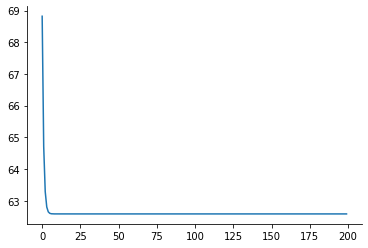

In [ ]:
gradient = jax.value_and_grad(jax.jit(neg_logjoint))
lr = 0.001
epochs = 200
theta_map = 0.5
losses = []
for i in trange(epochs):
    val, grad = gradient(theta_map)
    theta_map -= lr * grad
    losses.append(val)
plt.plot(losses)
sns.despine()
theta_map

### Verification of obtained $\theta_{map}$ value using the formula:

### $\theta_{map} = \frac{n_h+\alpha-1}{n_h+n_t+\alpha+\beta-2}$

In [ ]:
nH = samples.sum().astype("float32")
nT = (samples.size - nH).astype("float32")
theta_check = (nH + alpha - 1) / (nH + nT + alpha + beta - 2)
theta_check

DeviceArray(0.6698113, dtype=float32)

### Computing Hessian and Covariance

In [ ]:
hessian = jax.hessian(neg_logjoint)(theta_map)
hessian = jnp.reshape(hessian, (1, 1))
cov = jnp.linalg.inv(hessian)
cov

DeviceArray([[0.00208645]], dtype=float32)

### Plots Comparing the distribution obtained using Laplace approximation with actual Beta Bernoulli posterior

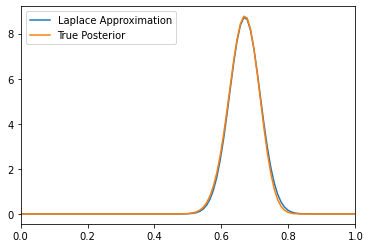

In [ ]:
x = jnp.linspace(0, 1, 100)
x = x.reshape(-1, 1)
Laplace_Approx = tfp.distributions.MultivariateNormalFullCovariance(
    loc=theta_map, covariance_matrix=cov
)
Laplace_Approx_pdf = Laplace_Approx.prob(x)
plt.plot(x, Laplace_Approx_pdf, label="Laplace Approximation")

alpha = 3
beta = 5
true_posterior = tfp.distributions.Beta(alpha + nH, beta + nT)
true_posterior_pdf = true_posterior.prob(x)
plt.plot(x, true_posterior_pdf, label="True Posterior")
plt.xlim(0, 1)
plt.legend()

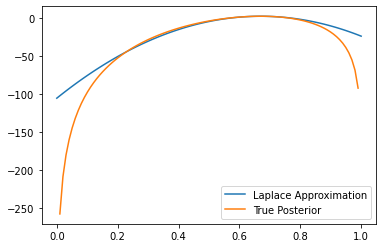

In [ ]:
# Using log_prob
true_posterior_pdf_log = true_posterior.log_prob(x)
Laplace_Approx_pdf_log = Laplace_Approx.log_prob(x)
plt.plot(x, Laplace_Approx_pdf_log, label="Laplace Approximation")
plt.plot(x, true_posterior_pdf_log, label="True Posterior")
plt.legend()